This notebook contains the analysis I did to estimate the periods of each star, and also the creation of plots in the final paper.

In [66]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import ccdproc as ccdp
from astropy.nddata import CCDData
from astropy.io import fits
from astropy import units as u


Load in our fluxes and separate by object 

In [67]:
flux_table = pd.read_csv('/home/toomeh/uw/spring-23/astr-480/final-project/flux.csv')
cccom_flux = flux_table[flux_table['Object Name'] == 'CCCom'].sort_values(by='image number').reset_index(drop=True)
tzboo_flux = flux_table[flux_table['Object Name'] == 'TZBoo'].sort_values(by='image number').reset_index(drop=True)

##### I want to add a new column with the timestamp for each of these images

In [68]:
calibrated_data = Path('/home/toomeh/uw/spring-23/astr-480/final-project/Data/reduced_images')
reduced_images = ccdp.ImageFileCollection(calibrated_data)

In [69]:
def move_file_to_index(lst, index0, indexf):
    item = lst.pop(index0)
    lst.insert(indexf, item)

In [70]:
reduced_tzboo = reduced_images.files_filtered(imagetyp = 'Light Frame', filter = 'V',object = 'Tz BOO',include_path=True, exptime=15)
reduced_cccom = reduced_images.files_filtered(imagetyp = 'Light Frame', filter = 'V',object = 'CC Com',include_path=True, exptime=15)
# moves the files in tzboo to be in the right order 
move_file_to_index(reduced_tzboo, 0, 2)


In [71]:
reduced_cccom

['/home/toomeh/uw/spring-23/astr-480/final-project/Data/reduced_images/CC_Com_15s_V_0_20230505_034737.fits',
 '/home/toomeh/uw/spring-23/astr-480/final-project/Data/reduced_images/CC_Com_15s_V_1_20230505_041450.fits',
 '/home/toomeh/uw/spring-23/astr-480/final-project/Data/reduced_images/CC_Com_15s_V_2_20230505_045800.fits']

In [74]:
def add_julian_date_column(reduced_images:ccdp.ImageFileCollection, flux_df:pd.DataFrame):
    """Adds a julian date column in place to the provided flux df 

    Args:
        reduced_images (ccdp.ImageFileCollection): reduced images to take the timestamp from
        flux_df (pd.DataFrame): the flux dataframe to add the timestamps to
    """
    julian_dates = []
    for file in reduced_images:
        with fits.open(file) as hdu:
            data = hdu[0].data
        jd = hdu[0].header['JD-OBS']
        julian_dates.append(jd)
    flux_df['Julian_Date'] =  julian_dates
    print(f'Successfully added julian date column to dataframe')
    return flux_df

tzboo_flux = add_julian_date_column(reduced_tzboo, tzboo_flux)
cccom_flux = add_julian_date_column(reduced_cccom, cccom_flux)


Successfully added julian date column to dataframe
Successfully added julian date column to dataframe


First I will plot the literature value of each objects variation with a few assumptions:

1. The flux variation is sinusoidal
2. the maximum flux values that we observed are at the peak of the sinusoid. 

In [84]:
tzboo_period_literature = 0.2976
tzboo_freq = 1/ tzboo_period_literature
start_tz = tzboo_flux['Julian_Date'].min()
stop_tz = tzboo_flux['Julian_Date'].max()
range_tz = stop_tz - start_tz
time_tz = np.linspace(start_tz , stop_tz, 1000)

In [85]:
tzboo_flux['Annulus Aperture Flux'] = tzboo_flux['Annulus Aperture Flux'].str.extract(r'(\d+\.?\d*)').astype(float)

AttributeError: Can only use .str accessor with string values!

Used Calculus to match the max of the sinusoid to the max value of my fluxes by shifting the sinusoid. 

In [86]:
delta_tz = 1 / (4*tzboo_freq) - tzboo_flux['Julian_Date'][2]

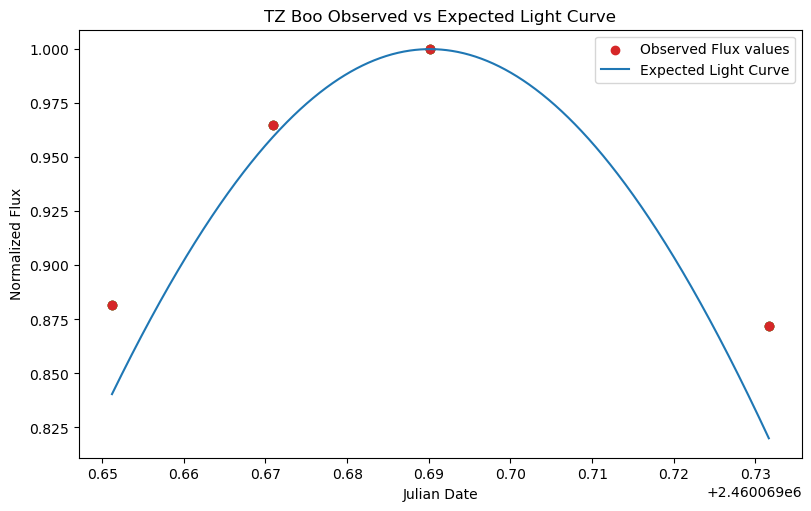

In [87]:
fig, ax = plt.subplots(
    figsize = (8, 5), 
    constrained_layout = True
)

for i in range(len(tzboo_flux)):
    # ax.plot(tzboo_flux['Julian_Date'], tzboo_flux['Annulus_Aperture_Flux'] / tzboo_flux['Annulus_Aperture_Flux'].max(),marker="o", markersize=10 )
     ax.scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), label = 'Observed Flux values' )

ax.plot(time_tz, 1/2*(np.sin(2* np.pi * tzboo_freq * (delta_tz+ time_tz))+ 1), label = 'Expected Light Curve')

ax.set_title('TZ Boo Observed vs Expected Light Curve')
ax.set_xlabel('Julian Date')
ax.set_ylabel('Normalized Flux')

# https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());
plt.autoscale()
# plt.savefig('./figures/TZBooLightCurve.png', bbox_inches='tight')

The method that was decided on was fitting a quadratic to the datapoints then using that fit quadratic to match with the quadratic taylor expansion of cos, then derive the frequency of that cosine function

In [94]:
from scipy.optimize import curve_fit
def quadratic(x,a,b,c): 
    return a + b*(x+c)**2

init_guesses_tz = [1,-70,-0.690130]
const = 2460069
x_tz = tzboo_flux['Julian_Date'] - const
y_tz =  tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max()

x_tz_plot = np.linspace(x_tz.min(), x_tz.max(), 1000)


fitpars_tz, error_tz = curve_fit(quadratic,
                           x_tz, y_tz,
                           p0 = init_guesses_tz)

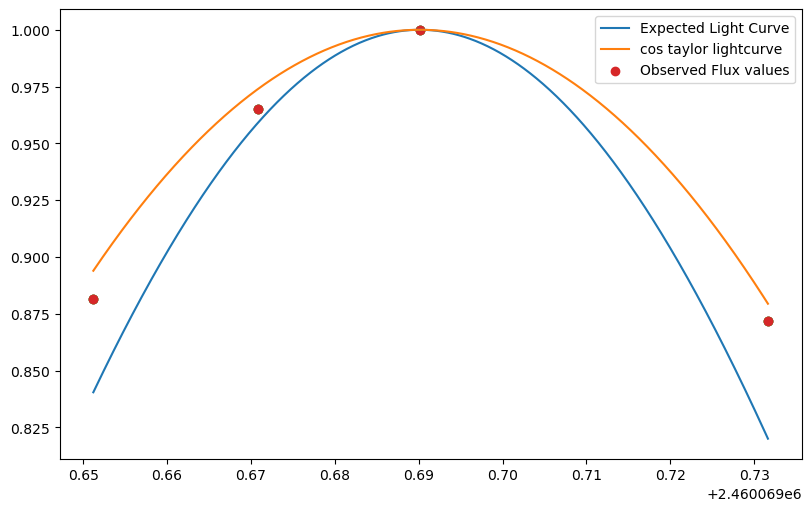

In [96]:
fig, ax = plt.subplots(
    figsize = (8, 5), 
    constrained_layout = True
)

ax.plot(time_tz, 1/2*(np.sin(2* np.pi * tzboo_freq * (delta_tz+ time_tz))+ 1), label = 'Expected Light Curve')
ax.plot(x_tz_plot + const,quadratic(x_tz_plot, *init_guesses_tz), label = 'cos taylor lightcurve')

for i in range(len(tzboo_flux)):
     ax.scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), label = 'Observed Flux values' )
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());
plt.autoscale()

get the period! 

In [97]:
def get_period(b):
    return np.sqrt(2) * np.pi / np.sqrt(np.abs(b))

In [99]:
taylor_period_tz =get_period(fitpars_tz[1])
print(f'The period predicted by the taylor expansion method for tz boo is: {taylor_period_tz:.5f} days')

The period predicted by the taylor expansion method for tz boo is: 0.51293 days


In [100]:
taylor_freq_tz = 1 / taylor_period_tz

In [101]:
taylor_delta_tz = 1 / (4*taylor_freq_tz) - tzboo_flux['Julian_Date'][2]

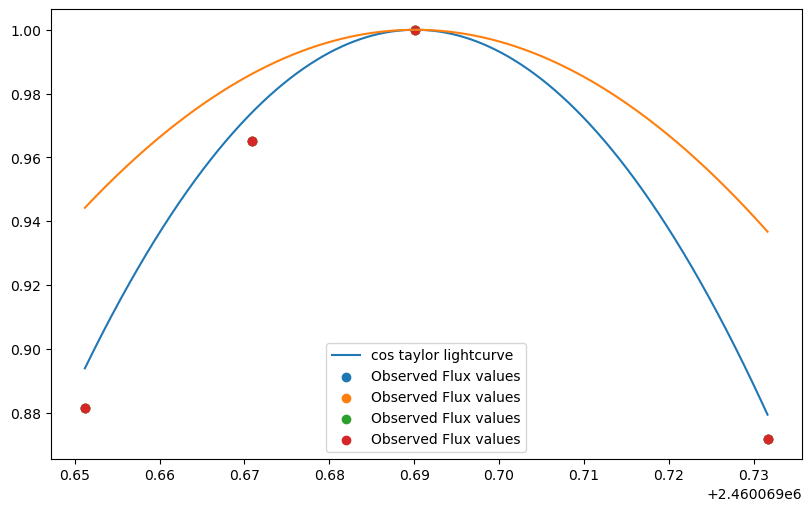

In [105]:
fig, ax = plt.subplots(
    figsize = (8, 5), 
    constrained_layout = True
)

# ax.plot(time_tz, 1/2*(np.sin(2* np.pi * tzboo_freq * (delta_tz+ time_tz))+ 1), label = 'Expected Light Curve')
ax.plot(x_tz_plot + const,quadratic(x_tz_plot, *init_guesses_tz), label = 'cos taylor lightcurve')
ax.plot(x_tz_plot + const, 1/2*(np.sin(2* np.pi * taylor_freq_tz * (taylor_delta_tz   + x_tz_plot + const))+ 1))
for i in range(len(tzboo_flux)):
     ax.scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), label = 'Observed Flux values' )
ax.legend()

# CC Com

In [106]:
cc_com_period_literature = 0.2210
cccom_freq = 1/ cc_com_period_literature
start_cc = cccom_flux['Julian_Date'].min()
stop_cc = cccom_flux['Julian_Date'].max()
time_cc = np.linspace(start_cc , stop_cc, 1000)

In [108]:
cccom_flux['Annulus Aperture Flux'] = cccom_flux['Annulus Aperture Flux'].str.extract(r'(\d+\.?\d*)').astype(float)

In [111]:
delta_cc= 1 / (4*cccom_freq) - cccom_flux['Julian_Date'][0]

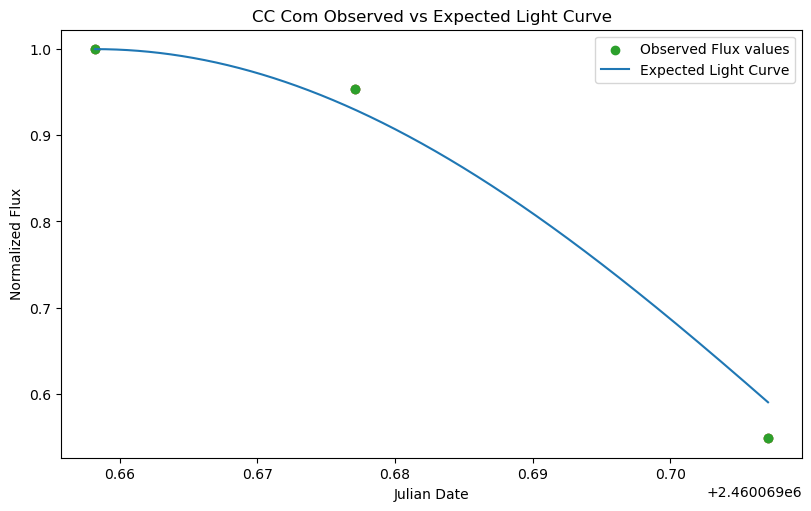

In [114]:
fig, ax = plt.subplots(
    figsize = (8, 5), 
    constrained_layout = True
)

for i in range(len(cccom_flux)):
     ax.scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), label = 'Observed Flux values' )

ax.plot(time_cc, 1/2*(np.sin(2* np.pi * cccom_freq * (delta_cc+ time_cc))+ 1), label = 'Expected Light Curve')

ax.set_title('CC Com Observed vs Expected Light Curve')
ax.set_xlabel('Julian Date')
ax.set_ylabel('Normalized Flux')



# https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());


In [116]:
x_cc = cccom_flux['Julian_Date'] - 2460069
y_cc =  cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max()
x_cc_plot = np.linspace(x_cc.min(), x_cc.max(), 1000)

In [117]:
init_guesses_cc = [1,-200,-0.6582124]

In [118]:
fitpars_cc, error_cc = curve_fit(quadratic,
                           x_cc, y_cc,
                           p0 = init_guesses_cc)

/tmp/ipykernel_157455/2477449174.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  fitpars_cc, error_cc = curve_fit(quadratic,


In [119]:
print(fitpars_cc)

[   1.00377048 -226.92131121   -0.66228865]


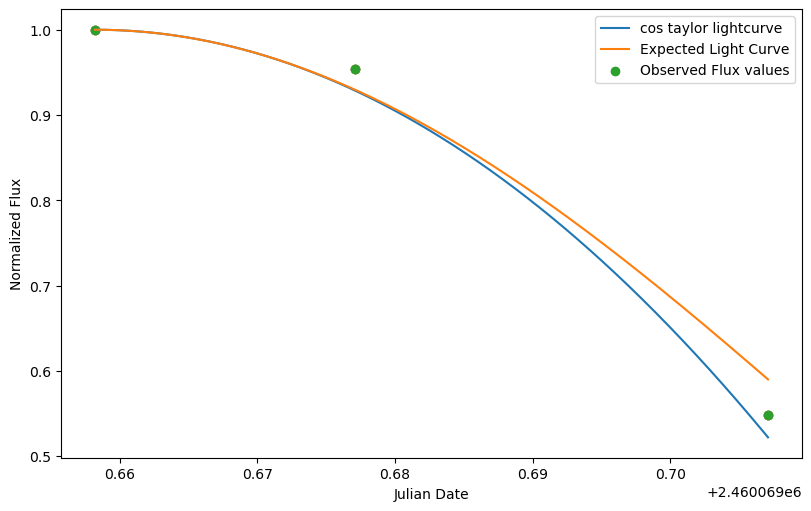

In [124]:
fig, ax = plt.subplots(
    figsize = (8, 5), 
    constrained_layout = True
)


ax.plot(x_cc_plot + const,quadratic(x_cc_plot, *init_guesses_cc), label = 'cos taylor lightcurve')

ax.plot(time_cc, 1/2*(np.sin(2* np.pi * cccom_freq * (delta_cc+ time_cc))+ 1), label = 'Expected Light Curve')

for i in range(len(cccom_flux)):
     ax.scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), label = 'Observed Flux values' )

ax.set_xlabel(f'Julian Date')
ax.set_ylabel('Normalized Flux')



handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

In [125]:
taylor_period_cc = get_period(fitpars_cc[1])
taylor_freq_cc = 1/ taylor_period_cc

print(f'The period predicted by the taylor expansion method for cc com is: {taylor_period_cc:.5f} days')

The period predicted by the taylor expansion method for cc com is: 0.29494 days


In [128]:
taylor_delta_cc = 1 / (4*taylor_freq_cc) - cccom_flux['Julian_Date'][0]

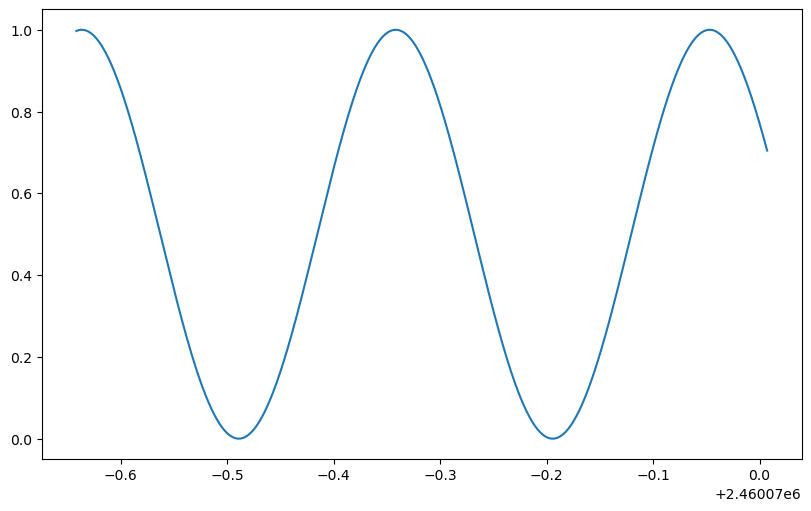

In [129]:
test_time_cc = np.linspace(start_cc-0.3 , stop_cc + 0.3, 1000)

fig, ax = plt.subplots(
    figsize = (8, 5), 
    constrained_layout = True
)

# ax.plot(test_time_cc, 1/2*(np.sin(2* np.pi * cccom_freq * (delta_cc+ test_time_cc))+ 1), label = 'Expected Light Curve')
ax.plot(test_time_cc, 1/2*(np.sin(2* np.pi * taylor_freq_cc * (taylor_delta_cc+ test_time_cc))+ 1), label = 'taylor')


# ax.plot(x_cc_plot + const,taylortestfunction(x_cc_plot, *init_guesses_cc), label = 'cos taylor lightcurve')


In [130]:
def percent_error(actual, expected):
    decimal = np.abs((actual - expected)/expected)
    return 100 * decimal

In [131]:
tz_percent = percent_error(taylor_period_tz, 0.2976)
print(f'The percent error of period of TZ Boo is: {tz_percent:.2f}%')

The percent error of period of TZ Boo is: 72.35%


In [132]:
cc_percent = percent_error(taylor_period_cc, 0.2210)
print(f'The percent error of period of CC Com is: {cc_percent:.2f}%')

The percent error of period of CC Com is: 33.46%


# Figure Factory 

This is where I created each of the figures that appear in the paper

In [66]:
#plt.savefig('../figures/Quadratic_Fit.png', bbox_inches='tight')

## Figure of raw data of both objects in a mosaic  

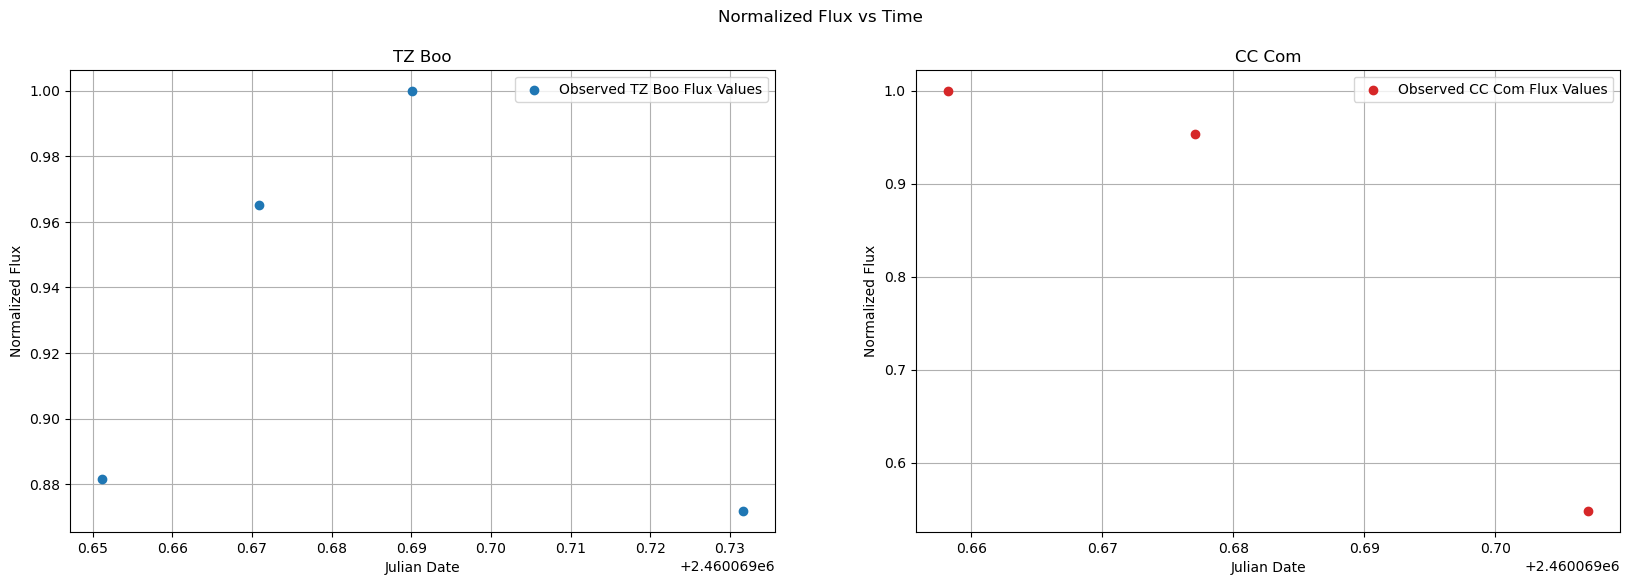

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

fig.suptitle('Normalized Flux vs Time')

axes[0].scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed TZ Boo Flux Values', 
               color = 'tab:blue')

axes[0].set_title('TZ Boo') 

axes[1].scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed CC Com Flux Values',
               color = 'tab:red')
axes[1].set_title('CC Com')       
for i in range(2):
    axes[i].legend()
    axes[i].set_xlabel('Julian Date')
    axes[i].set_ylabel('Normalized Flux')
    axes[i].set_axisbelow(True)
    axes[i].grid(True)


# plt.savefig('../figures/Raw_Fluxes.png', bbox_inches='tight')

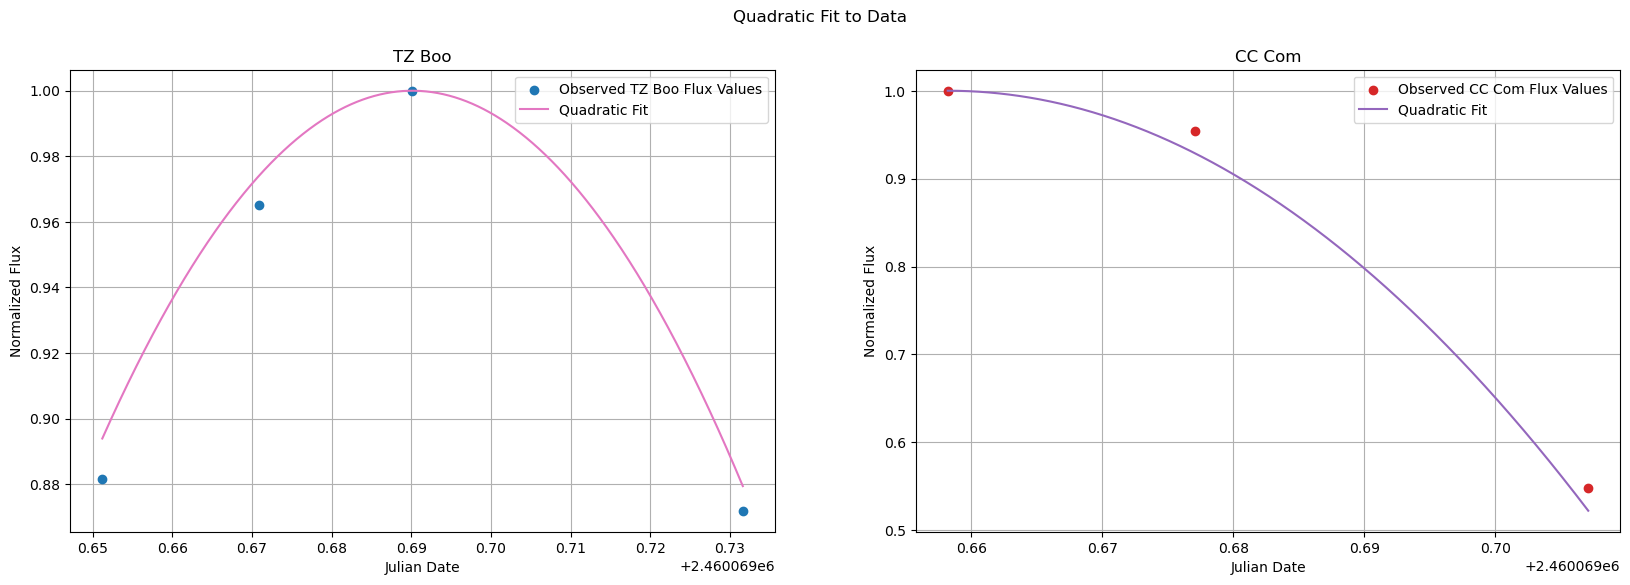

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

fig.suptitle('Quadratic Fit to Data')


axes[0].scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed TZ Boo Flux Values', 
               color = 'tab:blue')
axes[0].plot(x_tz_plot + const,quadratic(x_tz_plot, *init_guesses_tz), 
             label = 'Quadratic Fit',
            color = 'tab:pink')
axes[0].set_title('TZ Boo')  
axes[0].legend(loc = 'upper right')

axes[1].scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed CC Com Flux Values',
               color = 'tab:red')
axes[1].plot(x_cc_plot + const,quadratic(x_cc_plot, *init_guesses_cc), 
             label = 'Quadratic Fit', 
            color = 'tab:purple')
axes[1].legend(loc = 'upper right')

axes[1].set_title('CC Com')       
for i in range(2):
    axes[i].set_xlabel('Julian Date')
    axes[i].set_ylabel('Normalized Flux')
    axes[i].set_axisbelow(True)
    axes[i].grid(True)

# plt.savefig('../figures/Quadratic_Fit.png', bbox_inches='tight')

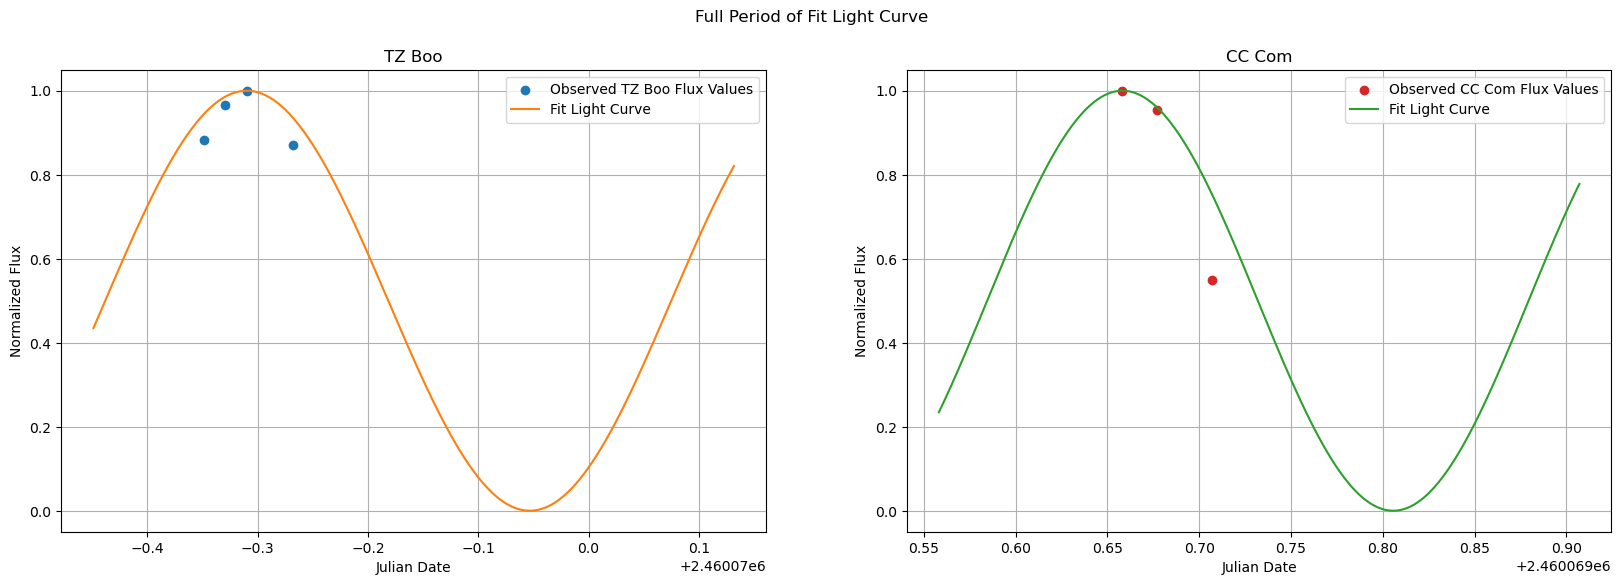

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
test_time_tz = np.linspace(start_tz-0.1 , stop_tz + 0.4,1000) 
# test_time_tz = np.linspace(start_tz -0.1, stop_tz + 0.2,1000) 
test_time_cc = np.linspace(start_cc-0.1 , stop_cc + 0.2, 1000)


fig.suptitle('Full Period of Fit Light Curve')
axes[0].set_title('TZ Boo')
axes[1].set_title('CC Com')

axes[0].scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed TZ Boo Flux Values', 
               color = 'tab:blue')
axes[0].plot(test_time_tz, 1/2*(np.sin(2* np.pi * taylor_freq_tz * (taylor_delta_tz   +test_time_tz))+ 1), 
            label = f'Fit Light Curve', 
            color = 'tab:orange')




axes[1].scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed CC Com Flux Values',
               color = 'tab:red')
axes[1].plot(test_time_cc, 1/2*(np.sin(2* np.pi * taylor_freq_cc * (taylor_delta_cc+ test_time_cc))+ 1),
            label = f'Fit Light Curve', 
            color = 'tab:green')
for i in range(2):
    axes[i].legend()
    axes[i].set_xlabel('Julian Date')
    axes[i].set_ylabel('Normalized Flux')
    axes[i].set_axisbelow(True)
    axes[i].grid(True)

    
# plt.savefig('../figures/full_period_taylor.png', bbox_inches='tight')

This will be a side by side showing the taylor, real curve, and raw data in a close up and zoomed out view. the close up will be on the left

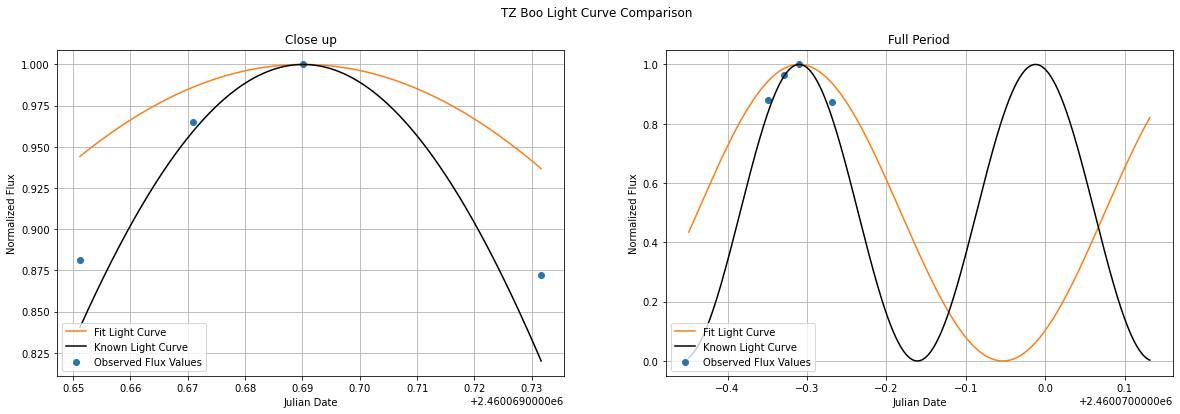

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
test_time_tz = np.linspace(start_tz-0.1 , stop_tz + 0.4,1000) 
# x_tz_plot + const



fig.suptitle('TZ Boo Light Curve Comparison')
axes[0].set_title('Close up')
axes[1].set_title('Full Period')

axes[0].scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed Flux Values', 
               color = 'tab:blue')
axes[0].plot(x_tz_plot + const, 1/2*(np.sin(2* np.pi * taylor_freq_tz * (taylor_delta_tz   +x_tz_plot + const))+ 1), 
            label = 'Fit Light Curve', 
            color = 'tab:orange')
axes[0].plot(x_tz_plot + const, 1/2*(np.sin(2* np.pi * tzboo_freq * (delta_tz+ x_tz_plot + const))+ 1),
             label = 'Known Light Curve', 
            color = 'k')




axes[1].scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed Flux Values', 
               color = 'tab:blue')
axes[1].plot(test_time_tz, 1/2*(np.sin(2* np.pi * taylor_freq_tz * (taylor_delta_tz   +test_time_tz))+ 1), 
            label = 'Fit Light Curve', 
            color = 'tab:orange')
axes[1].plot(test_time_tz, 1/2*(np.sin(2* np.pi * tzboo_freq * (delta_tz+ test_time_tz))+ 1), 
             label = 'Known Light Curve', 
            color = 'k')


for i in range(2):
    axes[i].legend(loc = 'lower left')
    axes[i].set_xlabel('Julian Date')
    axes[i].set_ylabel('Normalized Flux')
    axes[i].set_axisbelow(True)
    axes[i].grid(True)
    
# plt.savefig('../figures/tz_curve_compare.png', bbox_inches='tight')

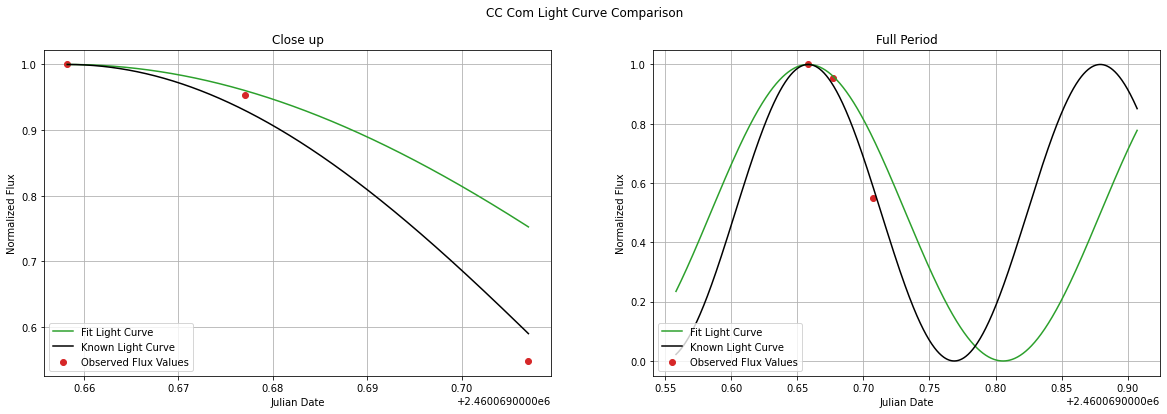

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
test_time_cc = np.linspace(start_cc-0.1 , stop_cc + 0.2, 1000)
# x_tz_plot + const


fig.suptitle('CC Com Light Curve Comparison')
axes[0].set_title('Close up')
axes[1].set_title('Full Period')

axes[0].scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed Flux Values', 
               color = 'tab:red')
axes[0].plot(x_cc_plot + const, 1/2*(np.sin(2* np.pi * taylor_freq_cc * (taylor_delta_cc   +x_cc_plot + const))+ 1), 
            label = 'Fit Light Curve', 
            color = 'tab:green')
axes[0].plot(x_cc_plot + const, 1/2*(np.sin(2* np.pi * cccom_freq * (delta_cc+ x_cc_plot + const))+ 1),
             label = 'Known Light Curve', 
            color = 'k')




axes[1].scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed Flux Values', 
               color = 'tab:red')
axes[1].plot(test_time_cc, 1/2*(np.sin(2* np.pi * taylor_freq_cc * (taylor_delta_cc   +test_time_cc))+ 1), 
            label = 'Fit Light Curve', 
            color = 'tab:green')
axes[1].plot(test_time_cc, 1/2*(np.sin(2* np.pi * cccom_freq * (delta_cc+ test_time_cc))+ 1), 
             label = 'Known Light Curve', 
            color = 'k')


for i in range(2):
    axes[i].legend(loc = 'lower left')
    axes[i].set_xlabel('Julian Date')
    axes[i].set_ylabel('Normalized Flux')
    axes[i].set_axisbelow(True)
    axes[i].grid(True)
    
# plt.savefig('../figures/cc_curve_compare.png', bbox_inches='tight')

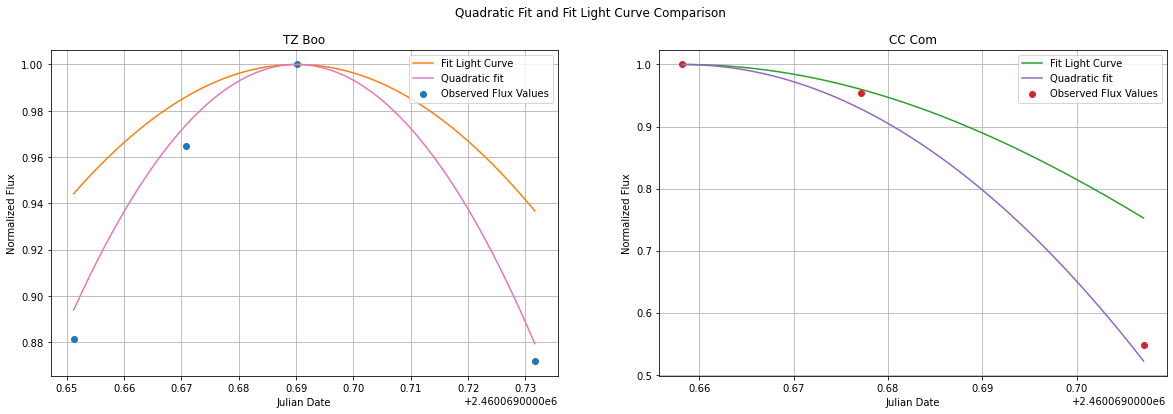

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
test_time_tz = np.linspace(start_tz-0.1 , stop_tz + 0.4,1000) 
# x_tz_plot + const



fig.suptitle('Quadratic Fit and Fit Light Curve Comparison')
axes[0].set_title('TZ Boo')
axes[1].set_title('CC Com')

axes[0].scatter(tzboo_flux['Julian_Date'], tzboo_flux['Annulus Aperture Flux'] / tzboo_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed Flux Values', 
               color = 'tab:blue')
axes[0].plot(x_tz_plot + const, 1/2*(np.sin(2* np.pi * taylor_freq_tz * (taylor_delta_tz   +x_tz_plot + const))+ 1), 
            label = 'Fit Light Curve', 
            color = 'tab:orange')
axes[0].plot(x_tz_plot + const,quadratic(x_tz_plot, *init_guesses_tz), 
             label = 'Quadratic fit',
            color = 'tab:pink')




axes[1].scatter(cccom_flux['Julian_Date'], cccom_flux['Annulus Aperture Flux'] / cccom_flux['Annulus Aperture Flux'].max(), 
                label = 'Observed Flux Values', 
               color = 'tab:red')
axes[1].plot(x_cc_plot + const, 1/2*(np.sin(2* np.pi * taylor_freq_cc * (taylor_delta_cc   +x_cc_plot + const))+ 1), 
            label = 'Fit Light Curve', 
            color = 'tab:green')
axes[1].plot(x_cc_plot + const,quadratic(x_cc_plot, *init_guesses_cc), 
             label = 'Quadratic fit',
            color = 'tab:purple')




for i in range(2):
    axes[i].legend(loc = 'upper right')
    axes[i].set_xlabel('Julian Date')
    axes[i].set_ylabel('Normalized Flux')
    axes[i].set_axisbelow(True)
    axes[i].grid(True)
    
# plt.savefig('../figures/quad_cos_compare.png', bbox_inches='tight')

In [73]:
tz_exp = tzboo_flux['Annulus_Aperture_Flux'] / tzboo_flux['Annulus_Aperture_Flux'].max()
tz_obs = 1/2*(np.sin(2* np.pi * taylor_freq_tz * (taylor_delta_tz   +tzboo_flux['Julian_Date']))+ 1)

In [74]:
cc_exp = cccom_flux['Annulus_Aperture_Flux'] / cccom_flux['Annulus_Aperture_Flux'].max()
cc_obs = 1/2*(np.sin(2* np.pi * taylor_freq_cc * (taylor_delta_cc   +cccom_flux['Julian_Date']))+ 1)